In [1]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# 1) Explore the data

### 1.1) Load in the data:

In [2]:
#load in the text file:
with open("SMSSpamCollection.txt") as f:
    content = f.readlines()
#initialize emty list that later will be transformed to final data frame:
l = []
#loop trhough lines, get rid of new line signs and save in list:
for line in content:
    line = line.strip("\n")
    c = line.split("\t")
    l.append(c)
#transform list to df:
df = pd.DataFrame.from_records(l)
#rename columns:
df.columns = ["class","sms"]
#change ham to 0 and spam to 1
ind = df.loc[:,"class"]=="ham"
df.loc[ind,"class"] = 0
df.loc[-ind,"class"] = 1
#print the head of the df:
df.head(40)


,class,sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


### 1b) Basic analysis on data set before cleaning:

(5574, 2)
False


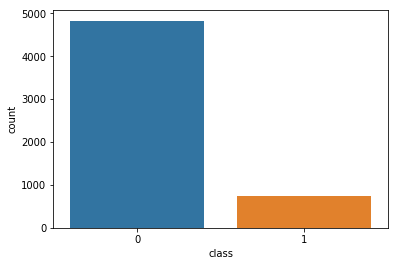

In [3]:
print(df.shape)
#check for Nas:
print(df.isnull().values.any())
#generate a count plot:
sns.countplot(x="class",data=df)


The df has 5574 rows and 2 columns (i.e. is it a spam or not and the content of the sms). The data set contains no NA's, so the reading of the file was successful. We can see that the data set is unbalanced with +/- 4800 sms being not spam, and around 800 sms being spam.

Lets check for doubles in the data:

In [4]:
print('Number of SMS:', df.sms.count())
print('Number of unique SMS: ', df.sms.nunique())


Number of SMS: 5574
Number of unique SMS:  5171


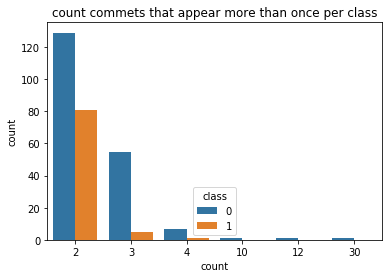

In [5]:
#Are the non-unique sms rather spam?

#set index to group on indexes:
df.set_index(['class','sms'],inplace=True)
#group by and get a count column:
df2 = pd.DataFrame(df.groupby(["sms","class"]).size())
df2.reset_index(inplace=True)
#get index of count larger than 1:
i = df2.iloc[:,2] > 1
df2.columns=["sms","class","count"]
df2 = df2[i]
#generate count plot:
sns.countplot(x="count",hue="class",data=df2)
plt.title('count commets that appear more than once per class')
plt.show()


#reset the index for the main data frame:
df.reset_index(inplace=True)

### SMS Length

Lets check the distribution of the length of SMS, once in general, then for spams and not spams and see if we can get a conclusion out of this:

C:\Users\rick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


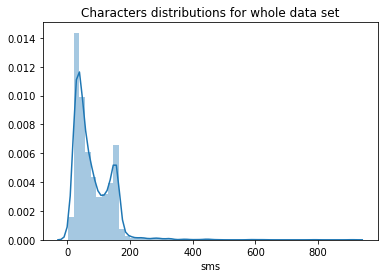

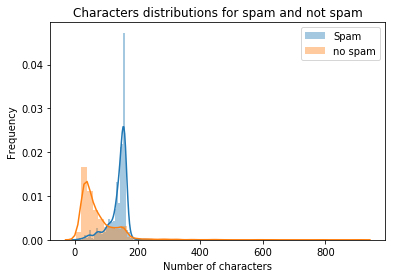

In [6]:
#distribution of comment lengths:

#whole data set:
sns.distplot(df['sms'].apply(len))
plt.title('Characters distributions for whole data set')
plt.show()

#spam:
ind = df.loc[:,"class"]==1
df_spam=df[ind]
sns.distplot(df_spam['sms'].apply(len),label="Spam")
#not spam:
df_not_spam=df[-ind]
ax = sns.distplot(df_not_spam['sms'].apply(len),label="no spam")
plt.legend()
plt.title('Characters distributions for spam and not spam')
ax.set(xlabel='Number of characters', ylabel='Frequency')
plt.show()



We can observe that the spam sms are longer on average, so it might be interesting to include the length of the sms as a feature.

In [7]:
df3 = df.copy()
df3['length'] = df3['sms'].apply(len)
df3.head(10)

,class,sms,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61
5,1,FreeMsg Hey there darling it's been 3 week's n...,148
6,0,Even my brother is not like to speak with me. ...,77
7,0,As per your request 'Melle Melle (Oru Minnamin...,160
8,1,WINNER!! As a valued network customer you have...,158
9,1,Had your mobile 11 months or more? U R entitle...,154


### Stopword presence

Another idea is the presence of stopwords, there could be a repetition of 'you' in spam messages as it would be an oriented commercial sms for example... 

It's also to check if we can clean the sms later on with stopwords. 

In [8]:
#SMS special characters count 
# creating a list with all reviews
sms = df.sms.tolist()

# creating special characters list
stopW = stopwords.words('english')

#empty list to save counts:
count_list = []
for s in sms:
    count = 0
    for c in s:
        if c in stopW :
            count = count + 1
    count_list.append(count)
    
#transform to series and add to df2 (which is a copy of df):
count_list = pd.Series(count_list)

df2 = df.copy()

df2['sw_count'] = count_list
df2.head()

,class,sms,sw_count
0,0,"Go until jurong point, crazy.. Available only ...",32
1,0,Ok lar... Joking wif u oni...,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,43
3,0,U dun say so early hor... U c already then say...,17
4,0,"Nah I don't think he goes to usf, he lives aro...",18


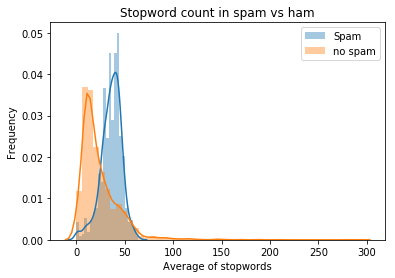

In [9]:
#spam:
ind = df2.loc[:,"class"]==1
df_spam=df2[ind]
sns.distplot(df_spam.loc[:,'sw_count'],label="Spam")

#not spam:
df_not_spam=df2[-ind]
ax = sns.distplot(df_not_spam.loc[:,'sw_count'],label="no spam")
plt.legend()
plt.title('Stopword count in spam vs ham')
ax.set(xlabel='Average of stopwords', ylabel='Frequency')
plt.show()

In [10]:
df3['sw_count'] = count_list
df3.head(10)

,class,sms,length,sw_count
0,0,"Go until jurong point, crazy.. Available only ...",111,32
1,0,Ok lar... Joking wif u oni...,29,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,43
3,0,U dun say so early hor... U c already then say...,49,17
4,0,"Nah I don't think he goes to usf, he lives aro...",61,18
5,1,FreeMsg Hey there darling it's been 3 week's n...,148,41
6,0,Even my brother is not like to speak with me. ...,77,29
7,0,As per your request 'Melle Melle (Oru Minnamin...,160,42
8,1,WINNER!! As a valued network customer you have...,158,40
9,1,Had your mobile 11 months or more? U R entitle...,154,50


### Special Characters count

Same idea as numerics in text, we could expect a lot of exclamation points, question marks etc. 
This special characters list can be modified to find the pattern that distinguishes between spam and no spam, like using $ or a lot of ! and ?

In [11]:
#SMS special characters count 
# creating a list with all reviews
sms = df.sms.tolist()

# creating special characters list
special_characters = ["@","?","$",".","£"] # "?" distinguishes a lot!! "?" & "." works nicely as well!

#empty list to save counts:
count_list = []
for s in sms:
    count = 0
    for c in s:
        if c in special_characters :
            count = count + 1
    count_list.append(count)
    
#transform to series and add to df2 (which is a copy of df):
count_list = pd.Series(count_list)

df2 = df.copy()

df2['sc_count'] = count_list
df2.head(10)

,class,sms,sc_count
0,0,"Go until jurong point, crazy.. Available only ...",8
1,0,Ok lar... Joking wif u oni...,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,0,U dun say so early hor... U c already then say...,6
4,0,"Nah I don't think he goes to usf, he lives aro...",0
5,1,FreeMsg Hey there darling it's been 3 week's n...,3
6,0,Even my brother is not like to speak with me. ...,2
7,0,As per your request 'Melle Melle (Oru Minnamin...,1
8,1,WINNER!! As a valued network customer you have...,4
9,1,Had your mobile 11 months or more? U R entitle...,1


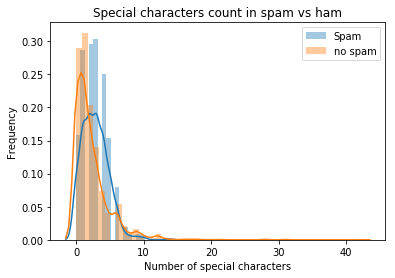

In [12]:
#spam:
ind = df2.loc[:,"class"]==1
df_spam=df2[ind]
sns.distplot(df_spam.loc[:,'sc_count'],label="Spam")

#not spam:
df_not_spam=df2[-ind]
ax = sns.distplot(df_not_spam.loc[:,'sc_count'],label="no spam")
plt.legend()
plt.title('Special characters count in spam vs ham')
ax.set(xlabel='Number of special characters', ylabel='Frequency')
plt.show()

Not the most clear-cut result... But could serve! Maybe we can improve by modifying the special characters list.

In [13]:
df3['sc_count'] = count_list
df3.head()

,class,sms,length,sw_count,sc_count
0,0,"Go until jurong point, crazy.. Available only ...",111,32,8
1,0,Ok lar... Joking wif u oni...,29,6,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,43,1
3,0,U dun say so early hor... U c already then say...,49,17,6
4,0,"Nah I don't think he goes to usf, he lives aro...",61,18,0


### Hyperlink presence

In [14]:
sms = df.sms.tolist()

#empty list to save counts:
count_list = []
for s in sms:
    count = 0
    count += s.count('www') + s.count('http') 
    count_list.append(count)
    
count_list = pd.Series(count_list)
count_list = (count_list >= 1)

df2 = df.copy()
df2['hyperlink'] = count_list
#hyperlinks = (df2.loc[:,'hyp'] >=1)
#df2['hyperlinks'] = hyperlinks

df2.head(20)

,class,sms,hyperlink
0,0,"Go until jurong point, crazy.. Available only ...",False
1,0,Ok lar... Joking wif u oni...,False
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,False
3,0,U dun say so early hor... U c already then say...,False
4,0,"Nah I don't think he goes to usf, he lives aro...",False
5,1,FreeMsg Hey there darling it's been 3 week's n...,False
6,0,Even my brother is not like to speak with me. ...,False
7,0,As per your request 'Melle Melle (Oru Minnamin...,False
8,1,WINNER!! As a valued network customer you have...,False
9,1,Had your mobile 11 months or more? U R entitle...,False


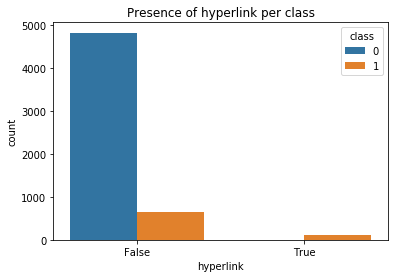

In [15]:
#count phone numbers per class:
sns.countplot(x="hyperlink",hue="class",data=df2)
plt.title('Presence of hyperlink per class')
plt.show()

In [16]:
df3['hyperlink'] = count_list
df3.head(10)

,class,sms,length,sw_count,sc_count,hyperlink
0,0,"Go until jurong point, crazy.. Available only ...",111,32,8,False
1,0,Ok lar... Joking wif u oni...,29,6,6,False
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,43,1,False
3,0,U dun say so early hor... U c already then say...,49,17,6,False
4,0,"Nah I don't think he goes to usf, he lives aro...",61,18,0,False
5,1,FreeMsg Hey there darling it's been 3 week's n...,148,41,3,False
6,0,Even my brother is not like to speak with me. ...,77,29,2,False
7,0,As per your request 'Melle Melle (Oru Minnamin...,160,42,1,False
8,1,WINNER!! As a valued network customer you have...,158,40,4,False
9,1,Had your mobile 11 months or more? U R entitle...,154,50,1,False


All messages that have an url are spam.

### Digit count + Phone nb presence

We might be interested to see if there is a phone number in a sms. A simple idea is to count hte number of single digits in a sms, and if the number is larger then 8, the probability is high that it is a phone number (an adress for example should have less than 8 digits). As a result, we need to come up with a function counting the digits in each sms:

In [17]:
#SMS digit count 
# creating a list with all reviews
sms = df.sms.tolist()
#empty list to save counts:
count_list = []
for s in sms:
    count = 0
    for c in s:
        if c.isdigit():
            count = count + 1
    count_list.append(count)
    
#transform to series and add to df2 (which is a copy of df):
count_list = pd.Series(count_list)

df2 = df.copy()

df2['digit_count'] = count_list
phone = (df2.loc[:,'digit_count'] > 8)
df2['phone'] = phone
df2.head()

,class,sms,digit_count,phone
0,0,"Go until jurong point, crazy.. Available only ...",0,False
1,0,Ok lar... Joking wif u oni...,0,False
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,25,True
3,0,U dun say so early hor... U c already then say...,0,False
4,0,"Nah I don't think he goes to usf, he lives aro...",0,False


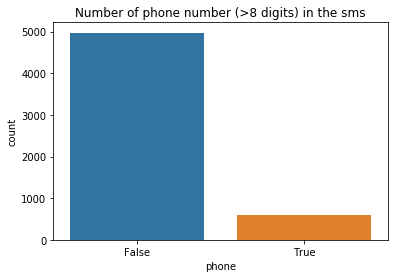

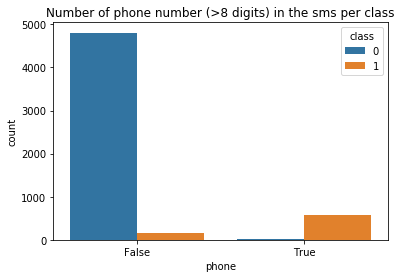

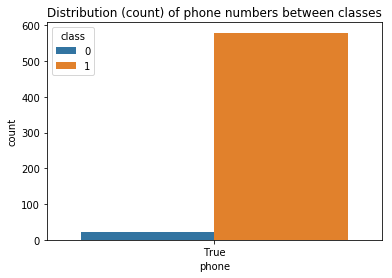

In [18]:
#make a count plot with phone numbers:
sns.countplot(x="phone",data=df2)
plt.title('Number of phone number (>8 digits) in the sms')
plt.show()

#count phone numbers per class:
sns.countplot(x="phone",hue="class",data=df2)
plt.title('Number of phone number (>8 digits) in the sms per class')
plt.show()

#look precisely at phone numbers for different classes:
ind = (df2.loc[:,"phone"] == True)
df4 = df2[ind]
sns.countplot(x="phone",hue="class",data=df4)
plt.title('Distribution (count) of phone numbers between classes')
plt.show()


In [19]:
df3['digit_count'] = count_list
phone = (df3.loc[:,'digit_count'] > 8)
df3['phone'] = phone
df3.head(10)

,class,sms,length,sw_count,sc_count,hyperlink,digit_count,phone
0,0,"Go until jurong point, crazy.. Available only ...",111,32,8,False,0,False
1,0,Ok lar... Joking wif u oni...,29,6,6,False,0,False
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,43,1,False,25,True
3,0,U dun say so early hor... U c already then say...,49,17,6,False,0,False
4,0,"Nah I don't think he goes to usf, he lives aro...",61,18,0,False,0,False
5,1,FreeMsg Hey there darling it's been 3 week's n...,148,41,3,False,4,False
6,0,Even my brother is not like to speak with me. ...,77,29,2,False,0,False
7,0,As per your request 'Melle Melle (Oru Minnamin...,160,42,1,False,1,False
8,1,WINNER!! As a valued network customer you have...,158,40,4,False,19,True
9,1,Had your mobile 11 months or more? U R entitle...,154,50,1,False,13,True


We get a very interesting insight from analysing phone numbers.

1) about 4900 sms's have not more than 8 digits (i.e. no phone numbers)  
2) around 600 sms's have a phone number in the text  
3) out of those 600, about 570 are marked as spam, only about 30 are not spam

As such, having more than 8 digits in the content might be a strong indicator for a spam sms.

### Smiley presence

In [20]:
sms = df.sms.tolist()

#empty list to save counts:
smileys = [':-)',':)','(-:','(:',':-(',':(',')-:','):',':o',':O',':0',':‑)'
           ,':)',':-]',':]',':-3',':3',':->',':>','8-)','8)',':-}',':}',':o)',
           ':c)',':^)','=]','=)']


count_list = []
for s in sms:
    count = 0
    for i in range(len(smileys)):
        count += s.count(smileys[i])
    count_list.append(count)
    
count_list = pd.Series(count_list)
weeb = (count_list > 1)

df2 = df.copy()
df2['smileys'] = count_list
df2['weeb'] = weeb

df2.head(10)

,class,sms,smileys,weeb
0,0,"Go until jurong point, crazy.. Available only ...",0,False
1,0,Ok lar... Joking wif u oni...,0,False
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,0,False
3,0,U dun say so early hor... U c already then say...,0,False
4,0,"Nah I don't think he goes to usf, he lives aro...",0,False
5,1,FreeMsg Hey there darling it's been 3 week's n...,0,False
6,0,Even my brother is not like to speak with me. ...,0,False
7,0,As per your request 'Melle Melle (Oru Minnamin...,0,False
8,1,WINNER!! As a valued network customer you have...,0,False
9,1,Had your mobile 11 months or more? U R entitle...,0,False


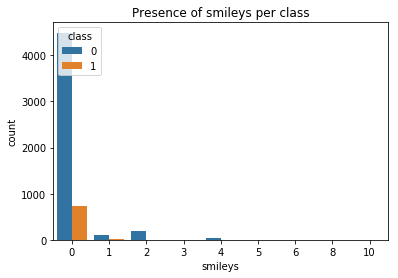

In [21]:
#count phone numbers per class:
sns.countplot(x="smileys",hue="class",data=df2)
plt.title('Presence of smileys per class')
plt.show()

Some spam can have on (very rarely 2) but only non spam have multiple emojis!

In [22]:
df3['smileys'] = count_list
df3['weeb'] = weeb
df3.head()

,class,sms,length,sw_count,sc_count,hyperlink,digit_count,phone,smileys,weeb
0,0,"Go until jurong point, crazy.. Available only ...",111,32,8,False,0,False,0,False
1,0,Ok lar... Joking wif u oni...,29,6,6,False,0,False,0,False
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,43,1,False,25,True,0,False
3,0,U dun say so early hor... U c already then say...,49,17,6,False,0,False,0,False
4,0,"Nah I don't think he goes to usf, he lives aro...",61,18,0,False,0,False,0,False


### Upper-case presence

Next, we might be interested to count upper case letters. The underlying assumption is that spam sms's might use upper case to attract attention, while normal sms's might use a lot less upp-case letters.

In [23]:
#count upper-case:
count_list = []
for s in sms:
    count = 0
    for c in s:
        if c.isupper():
            count = count + 1
    count_list.append(count)
count_list

#transform to series and add to df2 (which is a copy of df):
count_list = pd.Series(count_list)

df2['upper_case'] = count_list

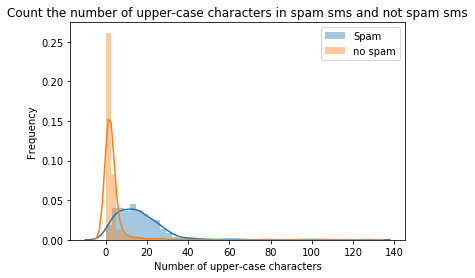

In [24]:
#spam:
ind = df2.loc[:,"class"]==1
df_spam=df2[ind]
sns.distplot(df_spam.loc[:,'upper_case'],label="Spam")

#not spam:
df_not_spam=df2[-ind]
ax = sns.distplot(df_not_spam.loc[:,'upper_case'],label="no spam")
plt.legend()
plt.title('Count the number of upper-case characters in spam sms and not spam sms')
ax.set(xlabel='Number of upper-case characters', ylabel='Frequency')
plt.show()

In [25]:
df3['upper_case'] = count_list
df3.head()

,class,sms,length,sw_count,sc_count,hyperlink,digit_count,phone,smileys,weeb,upper_case
0,0,"Go until jurong point, crazy.. Available only ...",111,32,8,False,0,False,0,False,3
1,0,Ok lar... Joking wif u oni...,29,6,6,False,0,False,0,False,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,43,1,False,25,True,0,False,10
3,0,U dun say so early hor... U c already then say...,49,17,6,False,0,False,0,False,2
4,0,"Nah I don't think he goes to usf, he lives aro...",61,18,0,False,0,False,0,False,2


While a lot of normal sms seem to have none upper-case characters, the spam emails tend to have more upper-case characters, which seems to confirm our. It might be a good idea to include the number of upper-case characters as a feature in our model.

TO DO 
before cleaning, as it might be of interests for features:

    1) number of special charcters in spam and not spam (DONE) - TO BE REVERSE ENGINEERED
    2) smileys (DONE)
    3) telephone numbers (DONE)
    4) hyperlinks (DONE)
    5) count upper case characters (spam might use upper case to attract attention) (DONE)
    6) most frquent words in general, spam and not spam - after cleaning (DONE)

### 1c) Conclusion of data analysis before cleaning:

The main conclusions of the data analysis are as follows:
    
1)Data set contains around 5600 sms  
2)Unbalanced data set, i.e. 800 spam, 4800 not spam  
3)Spam sms tend to be longer than not spam sms  
4)Around 600 sms contain phone number, almost all are spam  
5)Spam sms tend to have more upper-case letters than non-spam sms  

# 2) Clean the data:

###  2)a) Extract some features before cleaning:

For the final algorithm, we might want to extract some features based on special characters (before cleaning the data). This should be done in this section.

In [26]:
df3.head()

,class,sms,length,sw_count,sc_count,hyperlink,digit_count,phone,smileys,weeb,upper_case
0,0,"Go until jurong point, crazy.. Available only ...",111,32,8,False,0,False,0,False,3
1,0,Ok lar... Joking wif u oni...,29,6,6,False,0,False,0,False,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,43,1,False,25,True,0,False,10
3,0,U dun say so early hor... U c already then say...,49,17,6,False,0,False,0,False,2
4,0,"Nah I don't think he goes to usf, he lives aro...",61,18,0,False,0,False,0,False,2


### 2)b) Cleaning & Preprocessing:

We get rid of stopwords and certain punctuations (not dollar signs for example)

In [30]:
#FOR NOW (export as csv):
df3.to_csv("df_features.csv",index=False)

In [27]:
stopW = stopwords.words('english')
special_characters = ["@", "/", "#", ".", ",", "!", "?", "(", ")",
                      "-", "_","’","'", "\"", ":","=","+","&"
                      ,"`","*","0","1","2","3","4","5",
                      "6","7","8","9","'",'.','‘',';']
transformation_sc_dict = {initial:" " for initial in special_characters}

def preprocessing(sms):
  
    # Tokenization
    tokens = word_tokenize(sms)
    
    # Deleting words with  only one caracter
    tokens = [token for token in tokens if len(token)>2]
    
    # stopwords + lowercase
    tokens = [token.lower() for token in tokens if token.lower() not in stopW]   
    
    # Deleting specific characters
    tokens = [token.translate(str.maketrans(transformation_sc_dict)) for token in tokens]
        
    return tokens
  

# Creating a new column swith tokenized reviews
df3['tokens'] = df3['sms'].apply(preprocessing)
df3.head()

,class,sms,length,sw_count,sc_count,hyperlink,digit_count,phone,smileys,weeb,upper_case,tokens
0,0,"Go until jurong point, crazy.. Available only ...",111,32,8,False,0,False,0,False,3,"[jurong, point, crazy , available, bugis, gre..."
1,0,Ok lar... Joking wif u oni...,29,6,6,False,0,False,0,False,2,"[lar, , joking, wif, oni, ]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,43,1,False,25,True,0,False,10,"[free, entry, wkly, comp, win, cup, final, tkt..."
3,0,U dun say so early hor... U c already then say...,49,17,6,False,0,False,0,False,2,"[dun, say, early, hor, , already, say, ]"
4,0,"Nah I don't think he goes to usf, he lives aro...",61,18,0,False,0,False,0,False,2,"[nah, n t, think, goes, usf, lives, around, th..."


In [28]:
# creating a list with all reviews and more pre-processing
textos = df3.tokens.tolist()
texts = [[text.strip() for text in sms] for sms in textos]
clean_tokens = [[word for word in sms if word != ''] for sms in texts]
df3['clean_tokens'] = clean_tokens

NameError: name 'df_digit' is not defined

    - Now we define a function to consistently plot the most frequent words:

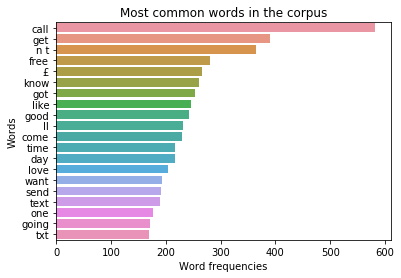

45113


In [ ]:
def plot_frequent_words(list_of_words):    
    dist = nltk.FreqDist(list_of_words)
    X = [nb[1] for nb in dist.most_common(20)]
    y = [nb[0] for nb in dist.most_common(20)]
    ax = sns.barplot(X,y)
    ax.set(xlabel='Word frequencies',ylabel='Words',title='Most common words in the corpus')
    plt.show()

all_words = []
for sms in clean_tokens:
    for text in sms:
        all_words.append(text)
    
plot_frequent_words(all_words)
print(len(all_words))

### 2)c)i) Additional analytics after cleaning

We can go more in detail and see the specificities of most frequent words in ham and spam seperately.

* Identifying spam and ham

In [ ]:
ind = df3.loc[:,"class"]==1
df_spam = df3[ind]
df_ham = df3[-ind]

* Applying the previous pre-processing as before

In [31]:
# Separating ham and spam and pre-processing them:
df_spam['tokens'] = df_spam['sms'].apply(preprocessing)
df_ham['tokens'] = df_ham['sms'].apply(preprocessing)

# creating a list with spam and ham respectively
textos_spam = df_spam.tokens.tolist()
textos_ham = df_ham.tokens.tolist()

# Additionnal pre-processing
texts_spam = [[text.strip() for text in sms] for sms in textos_spam]
texts_ham = [[text.strip() for text in sms] for sms in textos_ham]

clean_tokens_spam = [[word for word in sms if word != ''] for sms in texts_spam]
clean_tokens_ham = [[word for word in sms if word != ''] for sms in texts_ham]

/Users/laks/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/laks/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


* Plotting the results

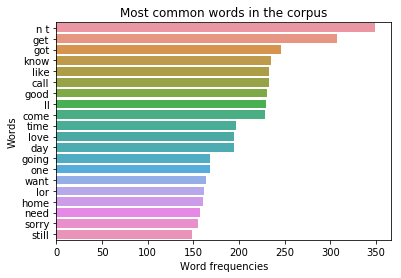

45113


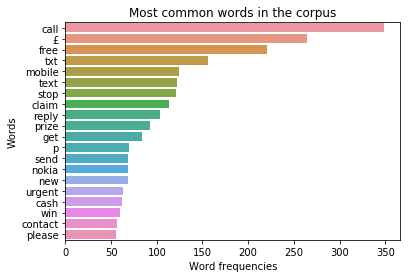

45113


In [32]:
all_words_ham = []
for sms in clean_tokens_ham:
    for text in sms:
        all_words_ham.append(text)
plot_frequent_words(all_words_ham)
print(len(all_words))

all_words_spam = []
for sms in clean_tokens_spam:
    for text in sms:
        all_words_spam.append(text)
plot_frequent_words(all_words_spam)
print(len(all_words))

We can already see that a few key-words will certainly help distinguish spam from ham : £, call, free, txt, mobile, prize etc... are buzzwords that you could expect from any commercial spam. Although we must be carefull as to not overfit our model and be able to detect only sms spams that resemble our data!

#### Lemmatiztion

We could consider using lemmatization to keep the root of the word only, although I don't think this might change much since we have a lot more grammar mistakes (done on purpose or not) given that sms are written more loosely. It might actually be an indicator for spam detection...

* Applying lemmatization

We just take the clean tokens that were preporcessed before for both ham and spam separately

In [33]:
df_ham['clean_tokens'] = clean_tokens_ham
df_spam['clean_tokens'] = clean_tokens_spam

lemmatizer = WordNetLemmatizer()
def lemmatize(tokens):
    tokens = [lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(token,pos='a'),pos='v'),pos='n') for token in tokens]
    return tokens  

df_ham['Lemmatisation'] = df_ham['clean_tokens'].apply(lemmatize)
df_spam['Lemmatisation'] = df_spam['clean_tokens'].apply(lemmatize)

/Users/laks/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/laks/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/laks/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

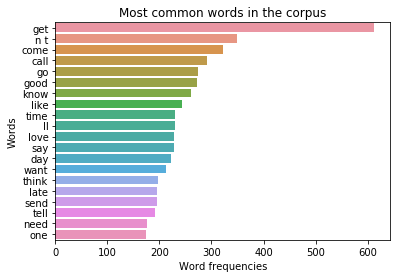

34792


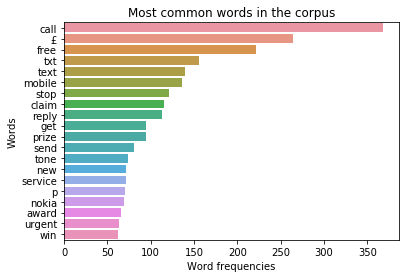

10321


In [34]:
all_words_ham = []
for sms in df_ham['Lemmatisation']:
    for text in sms:
        all_words_ham.append(text)
plot_frequent_words(all_words_ham)
print(len(all_words_ham))

all_words_spam = []
for sms in df_spam['Lemmatisation']:
    for text in sms:
        all_words_spam.append(text)
plot_frequent_words(all_words_spam)
print(len(all_words_spam))

We can't see any immediate effect but this might help for TF-IDF computations. Let's apply lemmatisation to our original data including both ham and spam:

In [35]:
df3['Lemmatisation'] = df3['clean_tokens'].apply(lemmatize)

### 2)c)ii) Results of analytics after cleaning

In [36]:
### CONCLUSION

In [37]:
### EXPORT FILES OR ALGORITHMS

In [38]:
print("Okay, you can merge!")